## Neural Network and Convolutional Neural Network Practice

Self taught deep learning using book "Deep Learning" published by O'Reilly.

The basic structure of neural network is a cell. The cell receiving input and generate output based on the input value. Sometimes people using activated to describe the input value is large enough to trigger cell to send output. The mathematic format can be expressed as $y = f(x)$, where $x$ is the input value, $f(x)$ is the activation function, and $y$ is the output value.

In [2]:
# import necessary package
import numpy as np

We usually have multiple input data, and multile cells in a layer. Matrix expression is easier for us to construct the neural network model. Thus, matrix operations such as addition, multiplication, and transpose are very important. Apply numpy function to check dimension is curcial. 

In [3]:
# basic notes for np array
x = np.array([[2,3,4],[5,6,7]])
print(x)
print('Use .shape to check x size: ' + str(x.shape))
print('Use .ndim to check x dimension: '+ str(x.ndim))

[[2 3 4]
 [5 6 7]]
Use .shape to check x size: (2, 3)
Use .ndim to check x dimension: 2


### Helper functions

#### Activation function

Step function is not a good choice for activating function in practical due to the sharp step at 0. The cell input values are usually processed by **Sigmoid** or **Relu** functions to create a smooth version input. For regression, the final results are directly used. For classification problem, **Softmax** function is commonly used to choice final selection.

In [4]:
# Sigmoid function, y = 1/(1+exp(-x))
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x) )

# ReLU, y = x if x>0 else 0
def relu(x):
    return np.maximum(0, x)

# gradient of sigmoid function, derive from dy/dx = 1/dx*(1/(1+exp(-x)))
def sigmoid_grad(x):
    return ( 1.0 - sigmoid(x) ) * sigmoid(x)

# gradient of relu function, derive from y=x if x>0 else 0
def relu_grad(x):
    grad = np.zeros(x)
    grad[x>0] = 1
    return grad

# softmax function, yk = exp(ak) / sum(exp(ai))
# the results can be treat as probability
def softmax(x):
    # directly implement the function will cause overflow error
    # return np.exp(x) / np.sum(exp_x)
    
    # substract max of x before exponential function to prevent error
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

#### Loss function
For all machine learning problems, we need a loss function to help our model learning (adjusting weights). Both mean square error function and cross entropy error function are commonly used in neural network. 

The mean square error function can be expressed as:

$E = \sum (y_h-y)^2$

The cross entropy error function can be expressed as:

$E = - \sum y\log y_h$

where $y$ is the true value, $y_h$ is model predicted value.

In [10]:
# error functions
# mse
def mse(y_h, y):
    return 0.5 * np.sum( (y_h-y)**2 )

# cross entropy error 1d version
def cross_entropy_error(y_h, y):
    delta = 1e-7 # prevent log function error
    return -np.sum( y * np.log(y_h+delta) )

### Practice 1: 1 layer network

First we build a simple 1 layer network with 3 cells can take 2 input values and can predict 3 different classes. The matrix form can be expressed as following:

$\begin{bmatrix}
X1 & X2
\end{bmatrix}
\begin{bmatrix}
W_{1,1} & W_{1,2} & W_{1,3}\\ 
W_{2,1} & W_{2,2} & W_{2,3}
\end{bmatrix} = \begin{bmatrix}
y_{h1} & y_{h2} & y_{h3}
\end{bmatrix}$

where $X_i$ is *i-th* input, $W_{ij}$ is weight of *i-th* input to *j-th* cell, $y_{hi}$ is *i-th* prediction.

In [19]:
# simple net practice
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
    
    def predict(self, x):
        return softmax(np.dot(x,self.W))
    
    def error(self, x, y):
        y_h = softmax(self.predict(x))
        return cross_entropy_error(y_h, y)

In [20]:
# initiate simple network
net = simpleNet()

# given inputs x1, x2 = 0.6, 0.9
x = np.array([0.6, 0.9])

# predict y
y_hat = net.predict(x)
print('Predicted probability: '+ str(y_hat))
idx = np.argmax(y_hat)
y_hat = np.zeros(y_hat.shape)
y_hat[idx] = 1
print('Predicted result: ' + str(y_hat))

# assume actual result is [0, 0, 1]
y =np.array([0, 0, 1])

# cross entropy error
error = net.error(x, y)
print('Cross Entropy Error: ' + str(error))

Predicted probability: [0.04099195 0.26444894 0.69455911]
Predicted result: [0. 0. 1.]
Cross Entropy Error: 0.7750146081970469


### Practice 2: 2 layers network

Second, build a simple 2 layers network with dynamic number of cell, input and output. The initial weights are set using random function. The general form of 1 layer matrix form can be expressed as following:

$\begin{bmatrix}
\cdots X_1 \cdots\\ 
\end{bmatrix}_{1,784}
\begin{bmatrix}
W_{1,1} &\cdots  & W_{1,100}\\
\vdots & & \vdots\\
W_{784,1} &\cdots  & W_{784,100}
\end{bmatrix}_{784,100}
+
\begin{bmatrix}
bias_1 \cdots bias_{100}
\end{bmatrix}_{1,100}
=
\begin{bmatrix}
l_1  \cdots l_{100}
\end{bmatrix}_{1,100}
$

The matrix form can easily be easily expanded to include more data in the same time, the input matrix and output matrix will become: 
$ \begin{bmatrix}
...X_1...\\ 
\vdots \\ 
...X_N...
\end{bmatrix}_{N,784} \begin{bmatrix}
l_{1,1}  \cdots l_{1,100} \\
\vdots \\ 
l_{N,1}  \cdots l_{N,100} 
\end{bmatrix}_{N,100} $

Therefore, we need to modify some helper functions to nable matrix multiplication. 

In [29]:
# Some helper functions need to modify for high dimension calculation
def softmax(x):
    if x.ndim == 2:
        x = x.T # convert x_i from row to column
        x = x - np.max(x, axis = 0) # axis = 0: vertical 
        y = np.exp(x) / np.sum(np.exp(x), axis = 0)
        return y.T # transpose back to original format

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

# for one-hot-encoding label
def cross_entropy_error(y, t):
    delta = 1e-7
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y+delta)) / batch_size

In [34]:
# 2 layers
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        
        # 1st layer size: from input to cell size
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        
        # 2nd layer size: from cell size to output size
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        # first layer: input * W1 + b1
        l1 = np.dot(x, self.params['W1']) +  self.params['b1']
        # use sigmoid function to smooth values
        z1 = sigmoid(l1)
        
        # second layer: input * W2 + b2
        l2 = np.dot(z1, self.params['W2']) + self.params['b2']
        # use softmax to normalize the result
        y_h = softmax(l2)
        
        return y_h # probability
    
    def error(self, x, y):
        y_h = self.predict(x)
        return cross_entropy_error(y_h, y)
    
    def accuracy(self, x, y):
        y_h = self.predict(x)
        # extract highest probability index, same as digit
        y_h = np.argmax(y_h, axis = 1)
        # convert one_hat_encode label back to digit
        y = np.argmax(y, axis = 1)
        # return correct # / total #
        return np.sum(y_h == y) / float(x.shape[0])
    
    # numerical gradient
    # the purpose showing numerical gradient function is 
    # to show how slow the method is.
    # graph gradient method is much faster.
    def numerical_gradient(self, x, y):
        pass
        #loss_W = lambda W: self.loss(x, t)
        #grads = {}
        #grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        #grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        #grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        #grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        #return grads
    
    # graph gradient
    def gradient(self, x, y):
        grads = {}
        
        batch_size = x.shape[0] # number of data used
        
        # forward
        l1 = np.dot(x, self.params['W1']) + self.params['b1']
        z1 = sigmoid(l1)
        l2 = np.dot(z1, self.params['W2']) + self.params['b2']
        y_h = softmax(l2)
        
        # backward
        dy = (y_h-y) / batch_size
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis = 0)
        
        dz1 = np.dot(dy, self.params['W2'].T)
        dl1 = sigmoid_grad(l1) * dz1
        grads['W1'] = np.dot(x.T, dl1)
        grads['b1'] = np.sum(dl1, axis = 0)
        
        return grads

In [36]:
# initiate two layers network with input size 784 (equals to 28*28 image size), 
# hidden layer with 100 cells, and output size 10 as 0~9 digits.
net = TwoLayerNet(input_size = 784, hidden_size = 100, output_size= 10)

# show the matrix size
print('1st layer weight matrix dimension: ' + str(net.params['W1'].shape))
print('1st layer bias vecotr dimension: ' + str(net.params['b1'].shape))
print('2nd layer weight matrix dimension: ' +str(net.params['W2'].shape))
print('2nd layer bias vector dimension: ' + str(net.params['b2'].shape))

# random assign value of 100 pics (28*28 pixel)
# size will be 100 pics * 784 pixel, means each row is a data point
x = np.random.rand(100,784)

# prediction
y = net.predict(x)

# random assign labels
t = np.random.rand(100, 10)

1st layer weight matrix dimension: (784, 100)
1st layer bias vecotr dimension: (100,)
2nd layer weight matrix dimension: (100, 10)
2nd layer bias vector dimension: (10,)


An important concept here is to understand how to use computational graph to estimate the gradient. The method is way faster than numerical gradient method.

### Apply 2 layers model to train and test MNIST data

In [37]:
import os
from mnist import MNIST
mnidata = MNIST(os.getcwd()+'/Data')
train_img, train_lab = mnidata.load_training()
test_img, test_lab = mnidata.load_testing()

In [38]:
train_data = np.array(train_img)
train_label = np.array(train_lab)
test_data = np.array(test_img)
test_label = np.array(test_lab)

# normalize image
train_data = train_data.astype(np.float32)
train_data /= 255.0
test_data = test_data.astype(np.float32)
test_data /= 255.0

# convert label to one hot encoding
def one_hot_encoding(labels, num_of_classes):
    res = np.eye(num_of_classes)[np.array(labels).reshape(-1)]
    return res.reshape(list(labels.shape)+[num_of_classes])

train_label = one_hot_encoding(train_label, 10)
test_label = one_hot_encoding(test_label, 10)

In [39]:
# apply mnist data, using 100 cells per layer
network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [40]:
# parameters
iteration_number = 10000
train_data_size = train_data.shape[0]
batch_data_size = 100
learning_rate = 0.1

train_error_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = train_data_size/batch_data_size

print('Training data size: ' + str(train_data.shape[0]))
print('Testing data size: ' + str(test_data.shape[0]))
print('1 epoch needs '+ str(iter_per_epoch)[:-2] + ' iteration' )
print('Note: epoch equals to size of training data')

Training data size: 60000
Testing data size: 10000
1 epoch needs 600 iteration
Note: epoch equals to size of training data


In [41]:
# training
for i in range(iteration_number):
    # mini-batch, using random function to randomly choicing data
    batch_selection = np.random.choice(train_data_size, batch_data_size)
    traing_data_batch = train_data[batch_selection]
    train_label_batch = train_label[batch_selection]
    
    # compute gradient
    grads = network.gradient(traing_data_batch, train_label_batch)
    
    # update weights
    # New Weights = Weights - learning_rate * Weights gradients
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grads[key]
        
    # record error
    error = network.error(traing_data_batch, train_label_batch)
    train_error_list.append(error)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(train_data, train_label)
        test_acc = network.accuracy(test_data, test_label)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("---- " + str(i//iter_per_epoch)[:-2] +" epoch" "----" )
        print("Training set accuracy: " + str(train_acc))
        print("Testing set accuracy: " + str(test_acc))

---- 0 epoch----
Training set accuracy: 0.0993
Testing set accuracy: 0.1032
---- 1 epoch----
Training set accuracy: 0.8146833333333333
Testing set accuracy: 0.8186
---- 2 epoch----
Training set accuracy: 0.87875
Testing set accuracy: 0.8848
---- 3 epoch----
Training set accuracy: 0.89835
Testing set accuracy: 0.9027
---- 4 epoch----
Training set accuracy: 0.9064666666666666
Testing set accuracy: 0.9108
---- 5 epoch----
Training set accuracy: 0.9128333333333334
Testing set accuracy: 0.9161
---- 6 epoch----
Training set accuracy: 0.9173333333333333
Testing set accuracy: 0.9185
---- 7 epoch----
Training set accuracy: 0.9216166666666666
Testing set accuracy: 0.9233
---- 8 epoch----
Training set accuracy: 0.92475
Testing set accuracy: 0.9248
---- 9 epoch----
Training set accuracy: 0.9277666666666666
Testing set accuracy: 0.9295
---- 10 epoch----
Training set accuracy: 0.9314666666666667
Testing set accuracy: 0.9324
---- 11 epoch----
Training set accuracy: 0.9346
Testing set accuracy: 0.935


Ploting results

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns

In [43]:
def squareFormat(x):
    square = np.array(x)
    square.resize(28,28)
    return square
    
def showImg(x,label):
    plt.imshow(x, cmap = 'gray')
    plt.title('Predicted digit: '+ str(label))
    plt.xticks([])
    plt.yticks([])

In [44]:
y_h = network.predict(test_data)
y_h = np.argmax(y_h, axis = 1)
y = np.argmax(test_label, axis = 1)

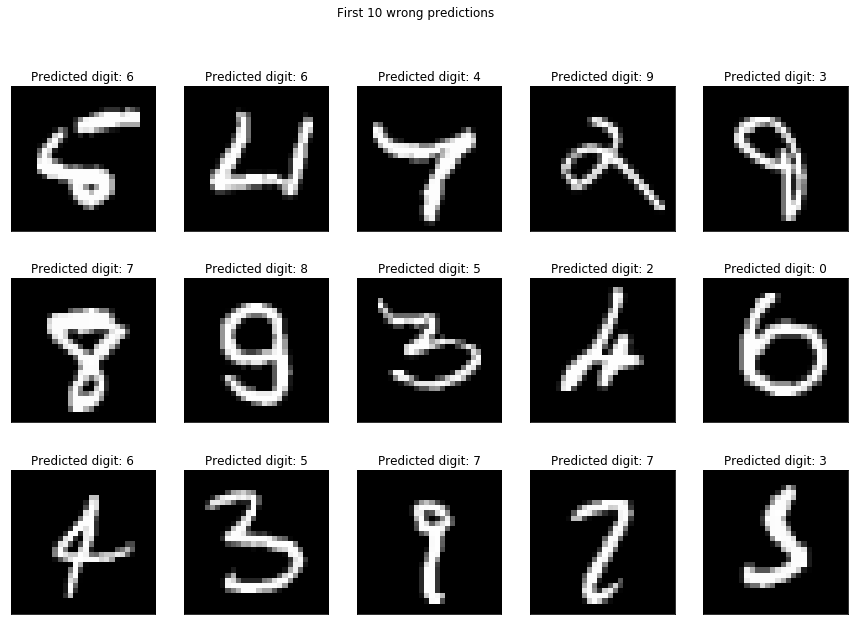

In [45]:
img = test_data[y_h!=y][0:15]
pre = y_h[y_h!=y][0:15]

fig = plt.figure(figsize = (15,10))
_ = fig.suptitle('First 10 wrong predictions')
for i in range(1,16):
    plt.subplot(3,5,i)
    showImg(squareFormat(img[i-1]), pre[i-1])